# Train on simple with pytorch

In [1]:
%matplotlib notebook

In [2]:
# imports
from pkg_resources import resource_filename
from importlib import reload

from matplotlib import pyplot as plt

import numpy as np


from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import copy
import time
from collections import defaultdict

from unetabs import spectraunet
from unetabs import data

In [3]:
reload(data)

<module 'unetabs.data' from '/home/xavier/Projects/Unet-abs/unetabs/data.py'>

## Load up

In [4]:
flux_file = resource_filename('unetabs', 'data/simple_flux.npy')
lbls_file = resource_filename('unetabs', 'data/simple_lbls.npy')

In [5]:
simple_train = data.AbsDataset(flux_file, lbls_file, mode='train', testing=True)

In [6]:
simple_valid = data.AbsDataset(flux_file, lbls_file, mode='validate', testing=True)

In [7]:
dataloaders = {}
dataloaders['train'] = DataLoader(simple_train, batch_size=4, shuffle=True)
dataloaders['valid'] = DataLoader(simple_valid, batch_size=4, shuffle=True)#, num_workers=4)

## Prep

In [8]:
#from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=1.0):

    #import pdb; pdb.set_trace()
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    #pred = F.sigmoid(pred)
    #dice = dice_loss(pred, target)
    
    loss = bce * bce_weight# + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, dataloaders, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for i_batch, sample_batched in enumerate(dataloaders[phase]):
                #import pdb; pdb.set_trace()
                inputs = sample_batched['image']
                labels = sample_batched['labels']
                inputs = inputs.to(device)
                labels = labels.to(device)#, torch.int64)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                if (i_batch%50) == 0:
                    print(i_batch)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Do it

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = spectraunet.SpectraUNet().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, dataloaders, optimizer_ft, exp_lr_scheduler, num_epochs=5)

cpu
Epoch 0/4
----------
LR 0.0001


/home/xavier/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


0
50
100
150
200
train: bce: 0.671727, loss: 0.671727
0
50
100
valid: bce: 0.526987, loss: 0.526987
saving best model
0m 41s
Epoch 1/4
----------
LR 0.0001
0
50
100
150
200
train: bce: 0.321753, loss: 0.321753
0
50
100
valid: bce: 0.049982, loss: 0.049982
saving best model
0m 44s
Epoch 2/4
----------
LR 0.0001
0
50
100
150
200
train: bce: 0.041483, loss: 0.041483
0
50
100
valid: bce: 0.036266, loss: 0.036266
saving best model
0m 59s
Epoch 3/4
----------
LR 0.0001
0
50
100
150
200
train: bce: 0.030427, loss: 0.030427
0
50
100
valid: bce: 0.028007, loss: 0.028007
saving best model
0m 59s
Epoch 4/4
----------
LR 0.0001
0
50
100
150
200
train: bce: 0.025162, loss: 0.025162
0
50
100
valid: bce: 0.023532, loss: 0.023532
saving best model
0m 46s
Best val loss: 0.023532


### Save

In [11]:
torch.save(model.state_dict(), 'simple_model_5.pt')

## Check spectral dimension
    Looks as desired

In [12]:
tst = simple_train[0]['image']
tst.shape

(1, 64, 64)

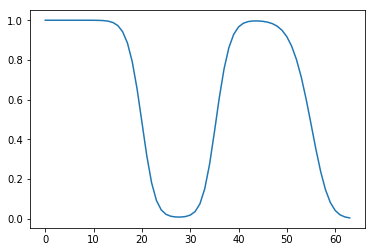

In [22]:
plt.clf()
ax = plt.gca()
ax.plot(tst[0,31,:])
#
plt.show()

## Check prediction

In [12]:
model.eval()

SpectraUNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): ReLU(inplace)
    (2): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (3): ReLU(inplace)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (3): ReLU(inplace)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (3): ReLU(inplace)
  )
  (maxpool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=(1, 2), mode=bilinear)
  (dconv_up2): Sequential(
    (0): Conv2d(96, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): ReLU(inplace)
    (2): Conv2d(32,

In [13]:
tst0 = simple_train[0]['image']

In [14]:
tmp0 = torch.from_numpy(tst0.reshape(1,1,64,64))

In [18]:
pred = F.sigmoid(model(tmp0))

/home/xavier/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/xavier/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [19]:
pred = pred.data.cpu().numpy()

<IPython.core.display.Javascript object>


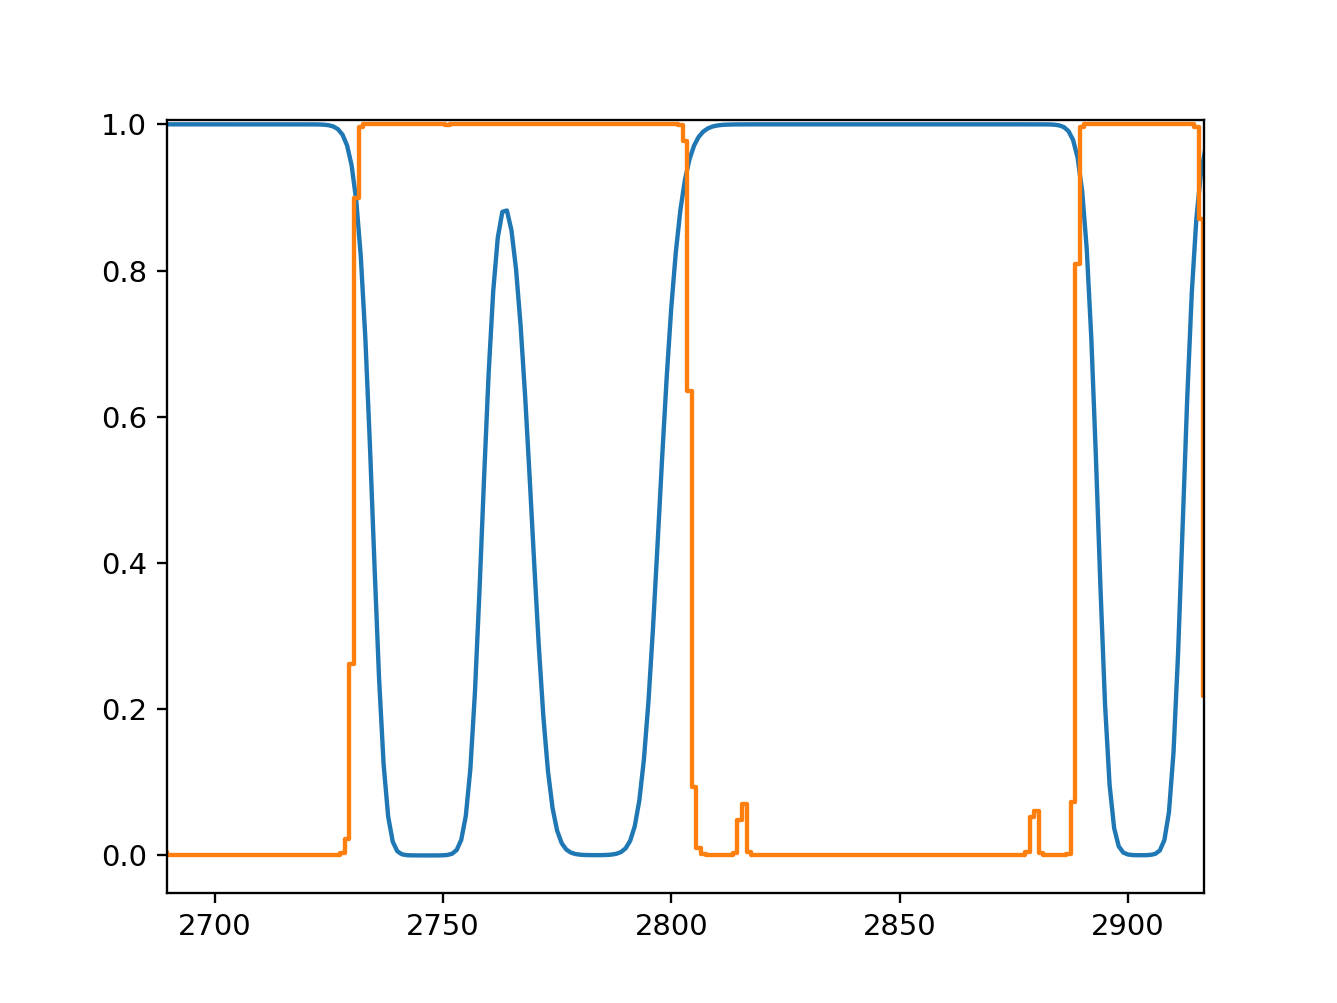

In [22]:
plt.clf()
ax = plt.gca()
ax.plot(tst0.flatten())
ax.plot(pred.flatten(), drawstyle='steps-mid')
#
plt.show()

### Exploring

In [23]:
tru_abs = tst0.flatten() < 0.95
pred_abs = pred.flatten() > 0.8

In [35]:
missed = tru_abs & (~pred_abs)
np.sum(missed) / np.sum(tru_abs)

0.026121902210314803

In [34]:
pred_abs[np.where(missed)[0] - 1] + pred_abs[np.where(missed)[0] + 1]

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True])

In [31]:
pred

array([[[[ -4.0595546,  -7.6746216, -11.870311 , ..., -12.524592 ,
           -9.184927 ,  -4.6254525],
         [ -4.0595546,  -7.6746216, -11.870311 , ..., -12.290053 ,
           -8.927714 ,  -4.4025164],
         [ -1.2082363,  -0.3315443,   2.2083533, ...,  -9.603927 ,
           -8.346844 ,  -4.9906974],
         ...,
         [ -4.479836 ,  -7.994699 , -10.454107 , ..., -12.557064 ,
           -9.214812 ,  -4.66037  ],
         [ -4.059557 ,  -7.674623 , -11.870313 , ..., -12.524592 ,
           -9.184927 ,  -4.6254525],
         [ -4.0595546,  -7.6746216, -11.870311 , ..., -12.524592 ,
           -9.184927 ,  -4.6254525]]]], dtype=float32)

----

In [9]:
tst = simple_train[0]['labels'] #.astype(np.float32)
tst

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [31]:
tmp = torch.from_numpy(tst.reshape(1,1,64,64))
#tmp2 = torch.tensor(tmp, dtype=torch.float32)
#tmp2.dtype

In [32]:
model(tmp)

/home/xavier/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


tensor([[[[0.0692, 0.0738, 0.0719,  ..., 0.0714, 0.0704, 0.0545],
          [0.0692, 0.0738, 0.0719,  ..., 0.0714, 0.0703, 0.0545],
          [0.0695, 0.0737, 0.0717,  ..., 0.0714, 0.0703, 0.0545],
          ...,
          [0.0693, 0.0738, 0.0719,  ..., 0.0714, 0.0704, 0.0545],
          [0.0692, 0.0738, 0.0719,  ..., 0.0714, 0.0704, 0.0545],
          [0.0692, 0.0738, 0.0719,  ..., 0.0714, 0.0704, 0.0545]]]],
       grad_fn=<MkldnnConvolutionBackward>)

----

In [14]:
unet = spectraunet.SpectraUNet()

In [15]:
inputs = torch.rand(1,1,64,64)

In [16]:
unet(inputs)

/home/xavier/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


tensor([[[[0.1393, 0.1366, 0.1343,  ..., 0.1326, 0.1320, 0.1312],
          [0.1390, 0.1376, 0.1352,  ..., 0.1327, 0.1368, 0.1267],
          [0.1399, 0.1371, 0.1357,  ..., 0.1318, 0.1362, 0.1305],
          ...,
          [0.1411, 0.1361, 0.1318,  ..., 0.1318, 0.1355, 0.1293],
          [0.1388, 0.1380, 0.1358,  ..., 0.1363, 0.1333, 0.1292],
          [0.1384, 0.1377, 0.1355,  ..., 0.1310, 0.1310, 0.1311]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [18]:
inputs.dtype

torch.float32

In [13]:
F.binary_cross_entropy_with_logits?

In [36]:
np.exp(-0.1)

0.9048374180359595